### Simple input LIF model with F2F conversion

In [1]:
import sys
#sys.path.append('/home/jovyan/brian2lava')
#sys.path.append('/home/carlo/Entwicklung/Python/brian2lava')
#sys.path.append('/home/francesco/Developing/B2L/brian2lava')
sys.path.append('/homes/jlubo/brian2lava')

In [2]:
from brian2 import *

In [3]:
# Import Brian2Lava
import brian2lava

# Set device
# models_dir='/home/francesco/Developing/B2L/brian2lava-models-master/models'
models_dir='/homes/jlubo/brian2lava-models/models'
# models_dir='/home/jlubo/brian2lava-models/models'
#models_dir=None
#set_device('lava', mode='flexible', hardware='CPU', models_dir=models_dir) # use flexible-model mode (with CPU, floating-pt.)
#set_device('lava', mode='preset', hardware='Loihi2', models_dir=models_dir) # use preset-model mode with Loihi 2
#set_device('lava', mode='preset', hardware='CPU', num_repr='float', models_dir=models_dir) # use preset-model mode with CPU (floating-pt. representation)
set_device('lava', mode='preset', hardware='Loihi2', num_repr='fixed', use_f2f=True, models_dir=models_dir) # use preset-model mode with CPU (fixed-pt. representation)
#set_device('runtime')
#prefs.codegen.target = 'numpy'
BrianLogger.log_level_debug()

The name of one or more of the models defined in the given model directory /homes/jlubo/brian2lava-models/models conflicts with the models existing in the base brian2lava library. User defined models will always override default ones. If you did not intend for this to happen, rename your model folders.


Preset models available:

lif -- /homes/jlubo/brian2lava-models/models/lif -- Loihi2-ready
alif -- /homes/jlubo/brian2lava-models/models/alif -- Loihi2-ready

These models have been loaded and can be imported from 'brian2lava.preset_mode.model_loader' by their name. Given the currently available models, you might run, for example: 'from brian2lava.preset_mode.model_loader import lif'.


In [4]:
from brian2lava import ModelLoader
ModelLoader.available_preset_models()

Preset models available:

lif -- /homes/jlubo/brian2lava-models/models/lif -- Loihi2-ready
alif -- /homes/jlubo/brian2lava-models/models/alif -- Loihi2-ready

These models have been loaded and can be imported from 'brian2lava.preset_mode.model_loader' by their name. Given the currently available models, you might run, for example: 'from brian2lava.preset_mode.model_loader import lif'.


In [5]:
# Import Loihi2 Lif models
from brian2lava.preset_mode.model_loader import lif

In [6]:
# Set seed
seed(1)

# Set defaultclock
defaultclock.dt = 0.5*ms

In [7]:
print(lif.equations, type(lif.equations))

dj/dt = -j/tau_j : V/s
dv/dt = -v/tau_v + j + bias : V (unless refractory) <class 'brian2.equations.equations.Equations'>


In [8]:
print(lif.conditions)

{'th': 'v > v_th', 'rs': 'v = v_rs'}


Latex equations                                                                 
--------------------------------------------------------------------------------


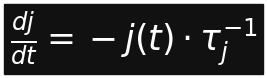

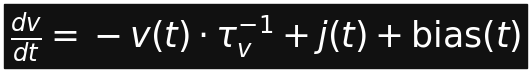

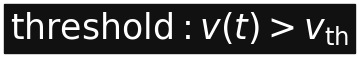

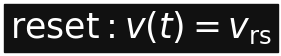



Raw equations                                                                   
--------------------------------------------------------------------------------
\frac{dj}{dt} = -j(t) \cdot \tau_j^{-1}                                         
\frac{dv}{dt} = -v(t) \cdot \tau_v^{-1} + j(t) + \mathrm{bias}(t)               
\mathrm{threshold} : v(t) > v_\mathrm{th}                                       
\mathrm{reset} : v(t) = v_\mathrm{rs}                                           


Variables                                                                       
--------------------------------------------------------------------------------
+--------+----------------+--------+
| name   | description    | unit   |
+========+================+========+
| j      | current (red.) | V/s    |
+--------+----------------+--------+
| v      | voltage        | V      |
+--------+----------------+--------+


Parameters                                                                      
------

In [9]:
lif.show()

In [10]:
# Define parameters
N = 3
bias = 0*mV/second #0*mV/ms
tau_j = 5*ms
tau_v = 10*ms
v_th = 50*mV
v_rs = -5*mV
ref = 2

# Add a spike generator group
S = SpikeGeneratorGroup(N, [0,1,2,0,2], [5,10,15,20,20]*ms)

# Add a neuron group (which receives a background input)
P = NeuronGroup(N, lif.equations, threshold=lif.conditions["th"], reset=lif.conditions["rs"], refractory='ref*ms', method='euler')
P.j = "0.03*mV/ms"
P.v = "2*mV"

# Add another neuron group (which does not receive a background input)
Q = NeuronGroup(N, lif.equations, threshold=lif.conditions["th"], reset=lif.conditions["rs"], refractory='ref*ms', method='euler')
#Q.j = "0.1*mV/ms"
Q.v = "2*mV"

# Add synapses
syn = Synapses(S, Q, model = 'w : volt/second', on_pre='j_post += w')
syn.connect(i=[0,1,2], j=[1])
syn.w = 50 * mV/second

DEBUG      Creating synapses from group 'spikegeneratorgroup' to group 'neurongroup_1', using pre-defined arrays) [brian2.synapses.synapses]


In [11]:
device = get_device()
device.code_object_class()

brian2.codegen.runtime.numpy_rt.numpy_rt.NumpyCodeObject

In [12]:
# Add monitor for spikes
#sm = SpikeMonitor(P)
#spmP = SpikeMonitor(P, variables='v', record=True)
#spmQ = SpikeMonitor(Q, variables='v', record=True)

# Add monitors for voltage and current
stmPv = StateMonitor(P, variables='v', record=True)
stmPj = StateMonitor(P, variables='j', record=True)
stmQv = StateMonitor(Q, variables='v', record=True)
stmQj = StateMonitor(Q, variables='j', record=True)

In [13]:
# Run simulation
run(30*ms)

DEBUG      Updated MagicNetwork to include 15 objects with names neurongroup_stateupdater, neurongroup, neurongroup_1_stateupdater, statemonitor_1, neurongroup_spike_resetter, statemonitor_2, neurongroup_1_spike_resetter, spikegeneratorgroup, synapses, synapses_pre, neurongroup_1_spike_thresholder, neurongroup_spike_thresholder, statemonitor, neurongroup_1, statemonitor_3 [brian2.core.magic.magic_objects]
DEBUG      Preparing network 'magicnetwork' with 15 objects: neurongroup, neurongroup_1, statemonitor, statemonitor_1, statemonitor_2, statemonitor_3, synapses, neurongroup_1_stateupdater, neurongroup_stateupdater, neurongroup_1_spike_thresholder, neurongroup_spike_thresholder, spikegeneratorgroup, synapses_pre, neurongroup_1_spike_resetter, neurongroup_spike_resetter [brian2.core.network.before_run]
DEBUG      Group neurongroup_1: using numerical integration method euler (took 0.03s) [brian2.stateupdaters.base.method_choice]
DEBUG      Group neurongroup: using numerical integration m

Import successful
Process model was found
Import successful
Process model was found
Running Lava simulation for 30. ms (60 steps)


DEBUG      Process 'neurongroup_1' initialized with NcL2ModelLif process model [brian2.devices.lava]
DEBUG      Running process: neurongroup, <class 'lava_workspace.Loihi2_preset_neurongroup.LIF'> [brian2.devices.lava]
DEBUG      Process 'neurongroup' initialized with NcL2ModelLif process model [brian2.devices.lava]
DEBUG      Successfully run simulation [brian2.devices.lava]
DEBUG      Got data from state probe referring to 'neurongroup.v' (N_tot = 3) [brian2.devices.lava]
DEBUG      Got data from state probe referring to 'neurongroup.j' (N_tot = 3) [brian2.devices.lava]
DEBUG      Got data from state probe referring to 'neurongroup_1.v' (N_tot = 3) [brian2.devices.lava]
DEBUG      Got data from state probe referring to 'neurongroup_1.j' (N_tot = 3) [brian2.devices.lava]
DEBUG      Successfully retrieved monitor values [brian2.devices.lava]
DEBUG      Updating Brian variables [brian2.devices.lava]
DEBUG      Successfully updated Brian variables! [brian2.devices.lava]


In [14]:
#stm2.variables['v'].get_value()
print(f"P.v = {P.v}")
print(f"P.j = {P.j}")
print(f"Q.v = {Q.v}")
print(f"Q.j = {Q.j}")
print(f"stmPv.t =\n{stmPv.t}")
print(f"stmPv.v =\n{stmPv.v}")
print(f"stmPj.j =\n{stmPj.j}")
print(f"stmQv.v =\n{stmQv.v}")
print(f"stmQj.j =\n{stmQj.j}")

P.v = <neurongroup.v: array([0.9765625, 0.9765625, 0.9765625]) * mvolt>
P.j = <neurongroup.j: array([0., 0., 0.]) * volt / second>
Q.v = <neurongroup_1.v: array([-4.8828125, -4.8828125, -4.8828125]) * mvolt>
Q.j = <neurongroup_1.j: array([0.0546875, 0.0546875, 0.0546875]) * volt / second>
stmPv.t =
<statemonitor.t: array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5]) * msecond>
stmPv.v =
[[ 1.953125   27.83203125 49.8046875  -4.8828125  14.16015625 29.78515625
  42.48046875 -4.8828125   6.8359375  16.11328125 23.4375     29.296875
  33.69140625 37.109375   39.55078125 41.015625   41.9921875  42.48046875
  42.48046875 41.9921875  41.015625   3

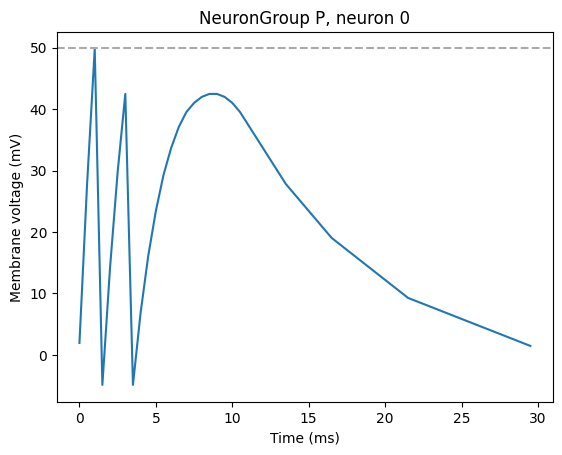

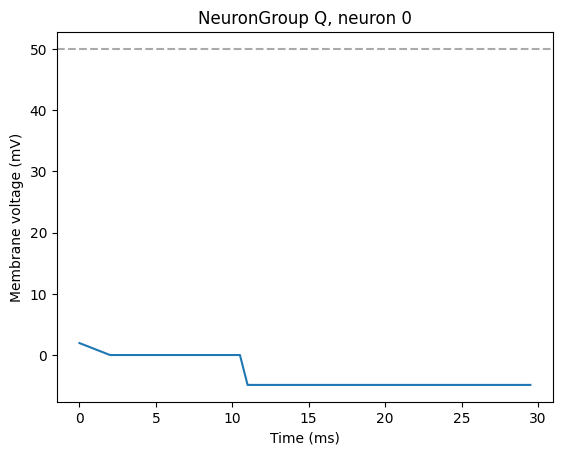

In [15]:
plt.plot(stmPv.t/ms,stmPv.v[0]/mV)
plt.axhline(v_th/mV, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup P, neuron 0')
xlabel('Time (ms)')
ylabel('Membrane voltage (mV)')
show()

plt.plot(stmQv.t/ms,stmQv.v[0]/mV)
plt.axhline(v_th/mV, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup Q, neuron 0')
xlabel('Time (ms)')
ylabel('Membrane voltage (mV)')
show()

In [16]:
#print(spmP.i)
#print(spmP.t/second)
#print(spmQ.i)
#print(spmQ.t/second)
#print(f"NeuronGroup P: {len(spmP.i)} spikes occurred in total.")
#print(f"NeuronGroup Q: {len(spmQ.i)} spikes occurred in total.")